In [1]:
# ===============================================
# پروژه: تشخیص تصاویر گل‌ها با دیپ‌لرنینگ
# تقسیم داده‌ها با train_test_split
# ===============================================
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# -------------------------------
# مرحله 1: مسیر دیتاست
# -------------------------------
dataset_dir = "flowers"  # پوشه‌ای که شامل سه پوشه rosa, tulip, daisy است

In [ ]:
import tensorflow as tf
import os
# پارامترهای augmentation
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),tf.keras.layers.RandomZoom(0.1),])
num_augmented_per_image = 2  # تعداد تصاویر جدید برای هر تصویر اصلی
img_height, img_width = 224, 224
dataset_dir = "flowers"  # همان پوشه اصلی
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for fname in os.listdir(class_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            img_path = os.path.join(class_path, fname)
            img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # اضافه کردن batch dimension
            # تولید تصاویر Augmented
            for i in range(num_augmented_per_image):
                augmented_img = data_augmentation(img_array)
                augmented_img = tf.keras.preprocessing.image.array_to_img(augmented_img[0])                
                # نام جدید برای تصویر Augmented
                new_fname = f"{os.path.splitext(fname)[0]}_aug_{i}.jpg"
                augmented_img.save(os.path.join(class_path, new_fname))
print("Augmentation and saving done!")

Augmentation and saving done!


In [4]:
# -------------------------------
# مرحله 2: خواندن تصاویر و برچسب‌ها
# -------------------------------
img_height, img_width = 224, 224
X = []
y = []
class_names = sorted(os.listdir(dataset_dir))
class_to_label = {name: idx for idx, name in enumerate(class_names)}
for class_name in class_names:
    class_path = os.path.join(dataset_dir, class_name)
    for fname in os.listdir(class_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            img_path = os.path.join(class_path, fname)
            img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
            img_array = tf.keras.utils.img_to_array(img)
            X.append(img_array)
            y.append(class_to_label[class_name])
X = np.array(X, dtype='float32') / 255.0  # نرمال‌سازی تصاویر
y = np.array(y)
print(f"Total images: {len(X)}, Classes: {class_names}")

Total images: 144, Classes: ['flower 1', 'flower 2', 'flower3']


In [5]:
# -------------------------------
# مرحله 3: تقسیم داده با train_test_split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (115, 224, 224, 3), Test shape: (29, 224, 224, 3)


In [6]:
# -------------------------------
# مرحله 4: Data Augmentation
# -------------------------------
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),layers.RandomRotation(0.1),])

In [7]:
# -------------------------------
# مرحله 6: ساخت مدل
# -------------------------------
base_model = MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
model = models.Sequential([layers.Input(shape=(224,224,3)),data_augmentation,base_model,
                           layers.GlobalAveragePooling2D(),
                           layers.Dense(102, activation='softmax')])  # تعداد کلاس‌ها

In [8]:
# -------------------------------
# مرحله 7: کامپایل مدل
# -------------------------------
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [9]:
# -------------------------------
# مرحله 8: آموزش مدل
# -------------------------------
history = model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=10,batch_size=32)

Epoch 1/10
4/4 [==============================] - 5s 642ms/step - loss: 4.1825 - accuracy: 0.0870 - val_loss: 2.2898 - val_accuracy: 0.4138
Epoch 2/10
4/4 [==============================] - 2s 418ms/step - loss: 1.7051 - accuracy: 0.6609 - val_loss: 1.0928 - val_accuracy: 0.5862
Epoch 3/10
4/4 [==============================] - 2s 415ms/step - loss: 0.8705 - accuracy: 0.7652 - val_loss: 0.7337 - val_accuracy: 0.6552
Epoch 4/10
4/4 [==============================] - 1s 351ms/step - loss: 0.5576 - accuracy: 0.8435 - val_loss: 0.5088 - val_accuracy: 0.7931
Epoch 5/10
4/4 [==============================] - 1s 352ms/step - loss: 0.3923 - accuracy: 0.9130 - val_loss: 0.3615 - val_accuracy: 0.9310
Epoch 6/10
4/4 [==============================] - 1s 387ms/step - loss: 0.2621 - accuracy: 0.9913 - val_loss: 0.2701 - val_accuracy: 0.9310
Epoch 7/10
4/4 [==============================] - 2s 468ms/step - loss: 0.2042 - accuracy: 0.9826 - val_loss: 0.2222 - val_accuracy: 0.9310
Epoch 8/10
4/4 [====

In [10]:
# -------------------------------
# مرحله 9: ارزیابی مدل
# -------------------------------
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

1/1 [==============================] - 0s 426ms/step - loss: 0.1230 - accuracy: 1.0000
Test Accuracy: 100.00%


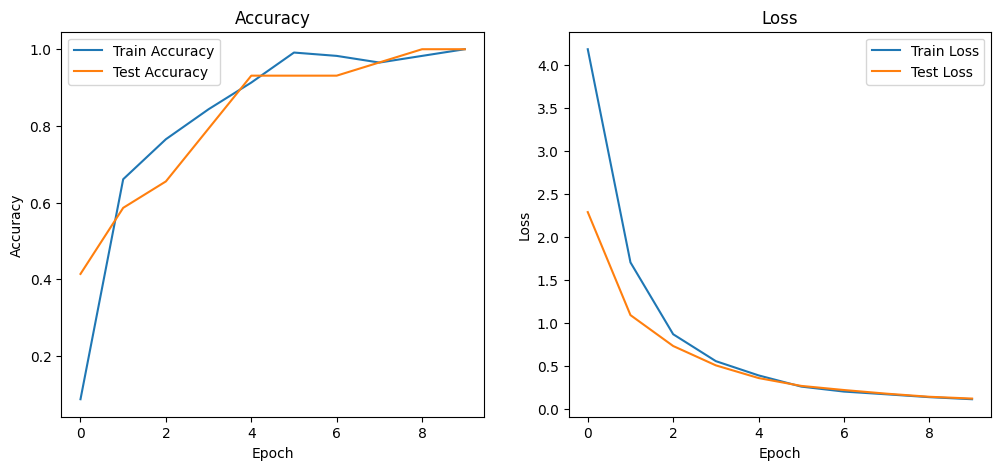

In [11]:
# -------------------------------
# مرحله 10: رسم نمودار
# -------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# -------------------------------
# مرحله 11: ذخیره مدل
# -------------------------------
model.save("flower_classifier_model.h5")
print("Model saved successfully!")

Model saved successfully!
